# Методы приближения функции

## Введение

Данная работа посвящена методам интерполяции и проверке их практической точности
и применимости. 

## Методология

В качестве примера для построения интерполяции возьмем данные переписи
населения США за 1910-2000 годы и, приблизив их разными методами, построим
интерполянты и путем экстраполяции найдем численность населения в 2010 году.
Интерполянты будем строить следующими методами:
1. Классическая полиномиальная интерполяция по Ньютону
2. Сплайн-интерполяция
3. Метод наименьших квадратов

## Исследование

In [4]:
import numpy as np

### Полиномиальная интерполяция по Ньютону

In [5]:
def newton_coeffs(x, y):
  """
  Вычисляет коэффициенты разделённых разностей для интерполяции Ньютона.
  Вход:
      x, y - одномерные numpy-массивы одинаковой длины n (x строго возрастающие не обязательно,
              но лучше, если x уникальны).
  Возвращает:
      coeffs - numpy-массив длины n, где coeffs[i] = a_i (коэффициент при i-ом базисном множителе).
  """
  x = np.asarray(x, dtype=float)
  y = np.asarray(y, dtype=float)
  n = x.size
  if n != y.size:
    raise ValueError("x и y должны иметь одинаковую длину")
  coef = y.copy().astype(float)
  for k in range(1, n):
    for j in range(n - k):
      denom = x[j + k] - x[j]
      if denom == 0:
        raise ZeroDivisionError(
          "Найдено одинаковое значение x: деление на ноль в разделённых разностях"
        )
      coef[j] = (coef[j + 1] - coef[j]) / denom

  a = np.empty(n, dtype=float)
  a[0] = y[0]
  dd = np.zeros((n, n), dtype=float)
  dd[:, 0] = y
  for j in range(1, n):
    for i in range(n - j):
      dd[i, j] = (dd[i + 1, j - 1] - dd[i, j - 1]) / (x[i + j] - x[i])
  a = dd[0, :].copy()
  return a


def newton_eval(x_nodes, coeffs, x_eval):
  """
  Оценивает полином Ньютона в точках x_eval.
  Вход:
      x_nodes - исходные узлы (x0..x_{n-1}) (numpy array)
      coeffs  - коэффициенты a0..a_{n-1} (как из newton_coeffs)
      x_eval  - скаляр или массив точек, где надо вычислить P(x)
  Возвращает:
      numpy-массив значений P(x_eval)
  """
  x_nodes = np.asarray(x_nodes, dtype=float)
  coeffs = np.asarray(coeffs, dtype=float)
  x_eval = np.asarray(x_eval, dtype=float)
  n = coeffs.size

  def eval_point(xp):
    res = coeffs[-1]
    for k in range(n - 2, -1, -1):
      res = res * (xp - x_nodes[k]) + coeffs[k]
    return res

  vec = np.vectorize(eval_point, otypes=[float])
  return vec(x_eval)

### Кубический сплайн с трехдиагональной прогонкой

In [6]:
def thomas_solve(a, b, c, d):
  """
  Thomas algorithm (прогонка) для трёхдиагонной системы.
  Система размера n:
      a[i] * x[i-1] + b[i] * x[i] + c[i] * x[i+1] = d[i],  i=0..n-1
  Требования:
      a[0] должен быть 0, c[-1] должен быть 0 (соответствие границ системы).
  Вход:
      a, b, c, d - numpy-массивы длины n (a[0] не используется, c[-1] не используется)
  Возвращает:
      x - решение (numpy-массив длины n)
  """
  a = np.asarray(a, dtype=float).copy()
  b = np.asarray(b, dtype=float).copy()
  c = np.asarray(c, dtype=float).copy()
  d = np.asarray(d, dtype=float).copy()
  n = b.size
  if not (a.size == n and c.size == n and d.size == n):
    raise ValueError("a, b, c, d должны иметь одинаковую длину")

  for i in range(1, n):
    if b[i - 1] == 0:
      raise ZeroDivisionError("Деление на ноль в прогонке")
    w = a[i] / b[i - 1]
    b[i] = b[i] - w * c[i - 1]
    d[i] = d[i] - w * d[i - 1]

  x = np.zeros(n, dtype=float)
  if b[-1] == 0:
    raise ZeroDivisionError("Деление на ноль в прогонке (в конце)")
  x[-1] = d[-1] / b[-1]
  for i in range(n - 2, -1, -1):
    x[i] = (d[i] - c[i] * x[i + 1]) / b[i]
  return x


def cubic_natural_spline_coeffs(x, y):
  """
  Вычисляет вторые производные (momенты) M_i для натурального кубического сплайна.
  Вход:
      x, y - одномерные numpy-массивы длины N (N >= 2), x строго возрастающие (рекомендуется).
  Возвращает:
      M - numpy-массив длины N с моментами (M[0]=M[-1]=0 для натурального сплайна)
  """
  x = np.asarray(x, dtype=float)
  y = np.asarray(y, dtype=float)
  N = x.size
  if N != y.size:
    raise ValueError("x и y должны иметь одинаковую длину")
  if N < 2:
    raise ValueError("Нужно хотя бы 2 точки")
  if N == 2:
    return np.array([0.0, 0.0])
  h = x[1:] - x[:-1]
  if np.any(h == 0):
    raise ValueError("Узлы x должны быть различны")

  n = N - 2
  a = np.zeros(n, dtype=float)  # нижняя диагональ (a[0] unused -> 0)
  b = np.zeros(n, dtype=float)  # главная диагональ
  c = np.zeros(n, dtype=float)  # верхняя диагональ (c[-1] unused -> 0)
  d = np.zeros(n, dtype=float)  # правая часть

  for i in range(1, N - 1):  # i = 1..N-2
    idx = i - 1  # индекс в 0..n-1
    hi_1 = h[i - 1]
    hi = h[i]
    a[idx] = hi_1
    b[idx] = 2 * (hi_1 + hi)
    c[idx] = hi
    d[idx] = 6 * ((y[i + 1] - y[i]) / hi - (y[i] - y[i - 1]) / hi_1)

  M_internal = thomas_solve(a, b, c, d)
  M = np.zeros(N, dtype=float)
  M[1:-1] = M_internal
  return M


def cubic_natural_spline_eval(x_nodes, y_nodes, M, x_eval):
  """
    Оценка натурального кубического сплайна, заданного узлами x_nodes, y_nodes и моментами M.
    Вход:
        x_nodes, y_nodes - узлы (длина N)
        M - моменты длины N (как из cubic_natural_spline_coeffs)
        x_eval - скаляр или массив точек
    Возвращает:
        значения сплайна в x_eval (numpy array)
    """
  x_nodes = np.asarray(x_nodes, dtype=float)
  y_nodes = np.asarray(y_nodes, dtype=float)
  M = np.asarray(M, dtype=float)
  x_eval = np.asarray(x_eval, dtype=float)
  N = x_nodes.size
  if not (y_nodes.size == N and M.size == N):
    raise ValueError("x_nodes, y_nodes, M должны иметь одинаковую длину")
  h = x_nodes[1:] - x_nodes[:-1]

  def eval_one(xp):
    if xp <= x_nodes[0]:
      k = 0
    elif xp >= x_nodes[-1]:
      k = N - 2
    else:
      k = np.searchsorted(x_nodes, xp) - 1
      if k < 0:
        k = 0
      elif k > N - 2:
        k = N - 2
    xk = x_nodes[k]
    xk1 = x_nodes[k + 1]
    hk = xk1 - xk
    if hk == 0:
      return y_nodes[k]
    A = (xk1 - xp) / hk
    B = (xp - xk) / hk
    val = (M[k] * (A**3) * hk**2 / 6.0 + M[k + 1] * (B**3) * hk**2 / 6.0 +
           (y_nodes[k] - M[k] * hk**2 / 6.0) * A +
           (y_nodes[k + 1] - M[k + 1] * hk**2 / 6.0) * B)
    return val

  vec = np.vectorize(eval_one, otypes=[float])
  return vec(x_eval)

### МНК

In [7]:
def gaussian_elimination(A, b, eps=1e-15):
  """
  Решает СЛАУ
  """
  n = len(A)
  M = [row[:] for row in A]
  bb = b[:]
  for k in range(n):
    piv = k
    maxv = abs(M[k][k])
    for i in range(k + 1, n):
      if abs(M[i][k]) > maxv:
        maxv = abs(M[i][k])
        piv = i
    if maxv < eps:
      raise ValueError("Cистема вырождена или плохо обусловлена.")
    if piv != k:
      M[k], M[piv] = M[piv], M[k]
      bb[k], bb[piv] = bb[piv], bb[k]
    for i in range(k + 1, n):
      factor = M[i][k] / M[k][k]
      for j in range(k, n):
        M[i][j] -= factor * M[k][j]
      bb[i] -= factor * bb[k]
  x = [0.0] * n
  for i in range(n - 1, -1, -1):
    s = bb[i]
    for j in range(i + 1, n):
      s -= M[i][j] * x[j]
    x[i] = s / M[i][i]
  return x

In [8]:
def design_matrix_polynomial(x, deg):
  """
  Построение матрицы A (n x (deg+1)), где столбцы: x^0, x^1, ..., x^deg
  """
  x = np.asarray(x, dtype=float)
  n = x.size
  A = np.vander(x, N=deg + 1, increasing=True)
  return A


def poly_least_squares(x, y, deg):
  """
  Аппроксимация методом наименьших квадратов полиномом степени deg.
  Вход:
      x, y - данные
      deg - степень полинома (int >= 0)
  Возвращает:
      coeffs - numpy-массив длины deg+1, порядок: [c0, c1, ..., c_deg]
  """
  x = np.asarray(x, dtype=float)
  y = np.asarray(y, dtype=float)
  if x.size != y.size:
    raise ValueError("x и y должны иметь одинаковую длину")
  if deg < 0 or int(deg) != deg:
    raise ValueError("deg должен быть неотрицательным целым")
  A = design_matrix_polynomial(x, deg)

  ATA = A.T @ A
  ATy = A.T @ y
  coeffs = gaussian_elimination(ATA, ATy)
  return coeffs

### Сравнение

Данные возьмем из VI.9.29.

In [24]:
import pandas as pd

us_population_data = pd.DataFrame(
  data={
    "year": [y for y in range(1910, 2020, 10)],
    "population": [
      92228496, 106021537, 123202624, 132164569, 151325798, 179323175,
      203211926, 226545805, 248709873, 281421906, 308745538
    ]
  })

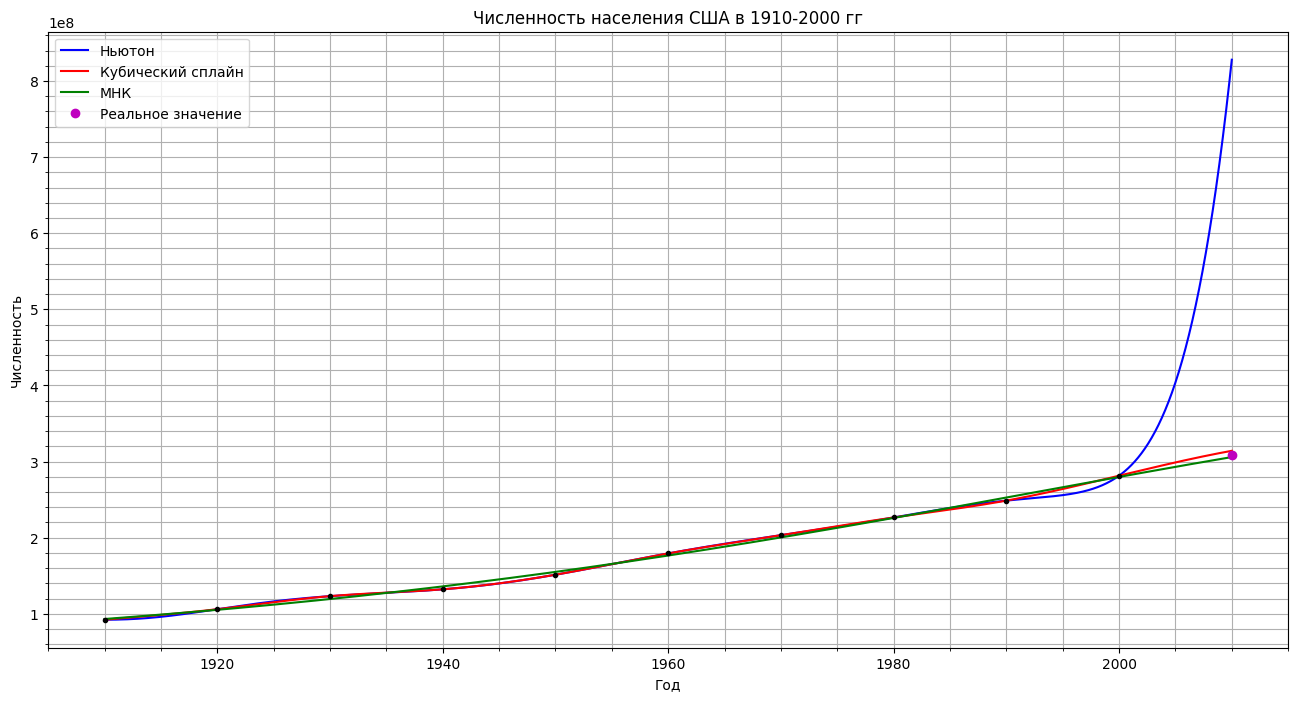

In [28]:
from matplotlib import pyplot as plt

year_full = us_population_data["year"]
pop_full = us_population_data["population"]

target_year = year_full[len(year_full) - 1]
target_pop = pop_full[len(pop_full) - 1]

year = year_full[:-1]
pop = pop_full[:-1]

x = np.linspace(1910, 2010, 1000)

nwtc = newton_coeffs(year, pop)
nwti = newton_eval(year, nwtc, x)

spline_moments = cubic_natural_spline_coeffs(year, pop)
spli = cubic_natural_spline_eval(year, pop, spline_moments, x)

DEGREE = 10
coeffs = poly_least_squares(year, pop, deg=DEGREE)
A = design_matrix_polynomial(x, deg=DEGREE)
lsqi = A @ coeffs

plt.figure(figsize=(16, 8))

plt.errorbar(year, pop, fmt="k.")
plt.errorbar(target_year, target_pop, fmt="mo", label="Реальное значение")
plt.plot(x, nwti, label="Ньютон", color="blue")
plt.plot(x, spli, label="Кубический сплайн", color="red")
plt.plot(x, lsqi, label="МНК", color="green")

plt.minorticks_on()
plt.grid(which="both")
plt.title("Численность населения США в 1910-2000 гг")
plt.xlabel("Год")
plt.ylabel("Численность")
plt.legend()

### Прогнозы и сравнения с реальным значением

Примечание: данные взяты по этой [ссылке](https://ru.wikipedia.org/wiki/%D0%9D%D0%B0%D1%81%D0%B5%D0%BB%D0%B5%D0%BD%D0%B8%D0%B5_%D0%A1%D0%A8%D0%90#%D0%A7%D0%B8%D1%81%D0%BB%D0%B5%D0%BD%D0%BD%D0%BE%D1%81%D1%82%D1%8C_%D1%81%D0%BE%D0%B3%D0%BB%D0%B0%D1%81%D0%BD%D0%BE_%D0%BF%D0%B5%D1%80%D0%B5%D0%BF%D0%B8%D1%81%D1%8F%D0%BC).

In [32]:
print(f"Прогноз численности в {target_year} году:")
print(f"Ньютон:{nwti[len(nwti) - 1]: .0f}")
print(f"Кубический сплайн:{spli[len(spli) - 1]: .0f}")
print(f"МНК:{lsqi[len(lsqi) - 1]: .0f}")

print(f"\nРеальное значение: {target_pop}")

Прогноз численности в 2010 году:
Ньютон: 827906509
Кубический сплайн: 314133939
МНК: 305900644

Реальное значение: 308745538


## Обсуждение результатов

Все методы кроме метода Ньютона дали очень точный прогноз (в пределах 1% погрешности).
Самым близким к реальности оказался прогноз методом сплайна.

Плохая пригодность метода Ньютона для экстраполяции объясняется высокой степенью
полинома и как следствие большими колебаниями за пределами области узлов интерполяции.